In [1]:
#Import needed packages

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.ensemble
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from matplotlib.dates import MonthLocator

/home/eric/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-23 13:16:43.671538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 13:16:44.436454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Load the dataset

Dataset = pd.read_csv('Data/superstore_data.csv')
print(Dataset.shape)
Dataset.head()
#make new dummy columns for the education and martial status value 
Dataset_dummy = pd.get_dummies(Dataset[['Marital_Status','Education']])

Dataset = pd.concat([Dataset,Dataset_dummy],axis=1)

Income_missing = Dataset[Dataset['Income'].isna()]
Rm_data = Dataset.dropna()
print(Rm_data.shape)
print(Income_missing.shape)

Income_missing.head()


(2240, 22)
(2216, 35)
(24, 35)


,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD
134,8996,1957,PhD,Married,NaN,2,1,11/19/2012,4,230,...,True,False,False,False,False,False,False,False,False,True
262,1994,1983,Graduation,Married,NaN,1,0,11/15/2013,11,5,...,True,False,False,False,False,False,False,True,False,False
394,3769,1972,PhD,Together,NaN,1,0,2/3/2014,17,25,...,False,False,True,False,False,False,False,False,False,True
449,5255,1986,Graduation,Single,NaN,1,0,2/20/2013,19,5,...,False,True,False,False,False,False,False,True,False,False
525,8268,1961,PhD,Married,NaN,0,1,11/7/2013,23,352,...,True,False,False,False,False,False,False,False,False,True


In [3]:
#Part 1) Train a method to impute the data from the column, train a random forest regressor for the income informaiton

impute_targ = Rm_data['Income']
impute_input = Rm_data.drop(columns=['Income','Dt_Customer','Marital_Status','Education'])

RandForest = sk.ensemble.RandomForestRegressor(n_estimators=200,random_state=1)

forest = RandForest.fit(impute_input,impute_targ)


#Impute the values for the missing cells and put it back into the dataset

impute_x = Income_missing.drop(columns=['Income','Dt_Customer','Marital_Status','Education'])
imputed_income = forest.predict(impute_x)

print(imputed_income)
#put this into the dataset
u = 0
for i in range(len(Dataset['Income'])):
    if pd.isna(Dataset['Income'][i]):
        Dataset['Income'][i] = imputed_income[u]
        u+= 1

Dataset['Edu_Cat'] = Dataset['Education'].astype('category').cat.codes
Dataset['Mat_Cat'] = Dataset['Marital_Status'].astype('category').cat.codes
Dataset.to_csv('Data/Imputed_Income.csv')

list_nan = Dataset[Dataset['Income'].isna()]
print(list_nan)
print('I finished')
#See the new dataset
Dataset.head()


[ 51078.355  29216.59   36802.655  81778.445  56609.535  24289.62
  50754.065  33256.42   30508.015  59731.215 126175.41   28259.065
  61559.22   74401.135  79679.62   50848.085  35094.985  40814.03
  50634.985  73667.825  40992.895  48684.175  44212.2    66019.515]
Empty DataFrame
Columns: [Id, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, Response, Complain, Marital_Status_Absurd, Marital_Status_Alone, Marital_Status_Divorced, Marital_Status_Married, Marital_Status_Single, Marital_Status_Together, Marital_Status_Widow, Marital_Status_YOLO, Education_2n Cycle, Education_Basic, Education_Graduation, Education_Master, Education_PhD, Edu_Cat, Mat_Cat]
Index: []

[0 rows x 37 columns]
I finished


/tmp/ipykernel_13511/4219940203.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Dataset['Income'][i] = imputed_income[u]
/tmp/ipykernel_13511/4219940203.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Edu_Cat,Mat_Cat
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,False,False,False,False,False,True,False,False,2,2
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,False,False,False,False,False,True,False,False,2,4
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,False,False,False,False,False,True,False,False,2,3
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,True,False,False,False,False,True,False,False,2,5
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,False,False,False,False,False,True,False,False,2,4


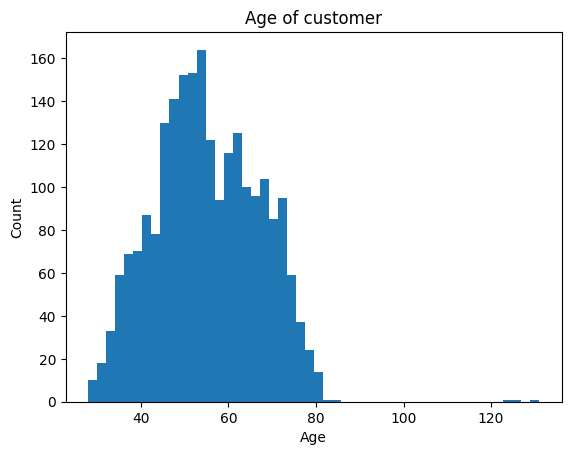

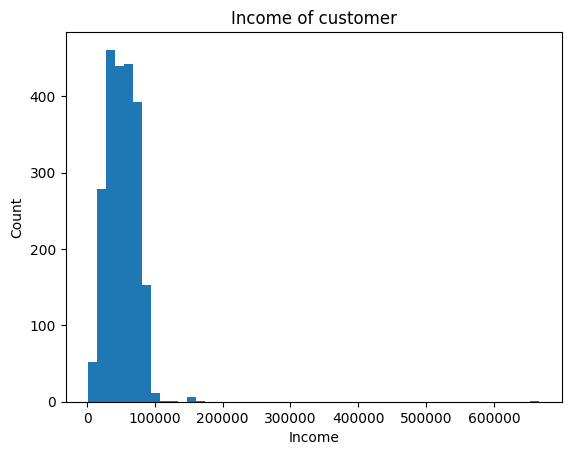

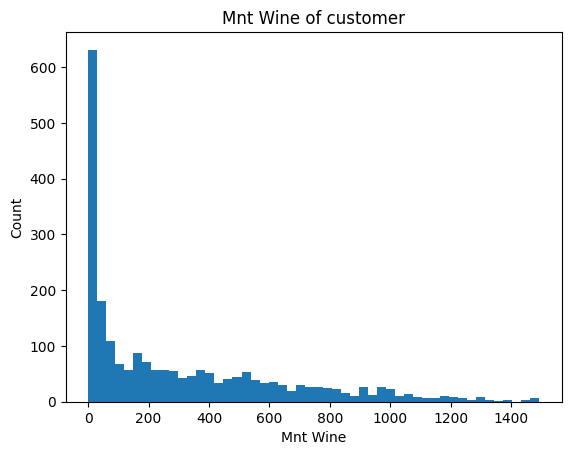

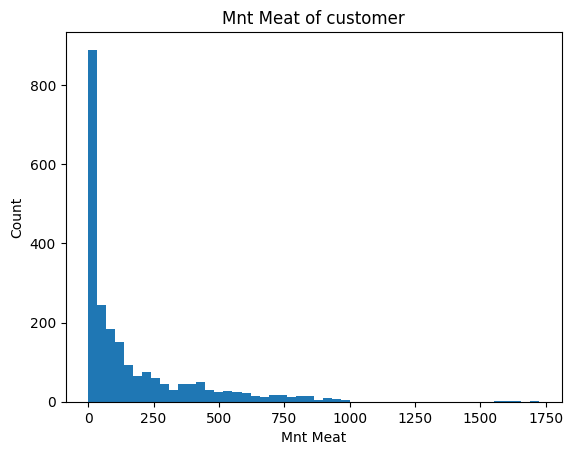

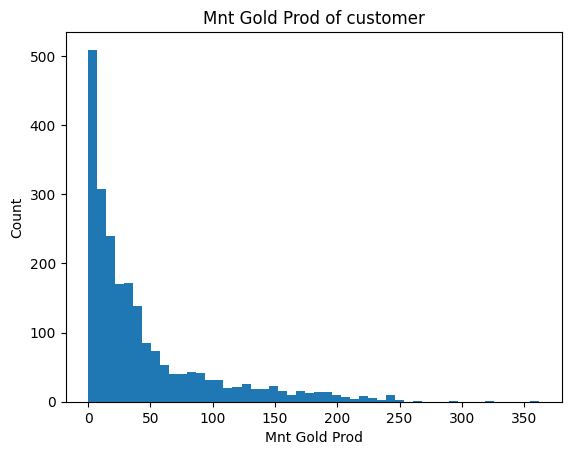

In [4]:
#Part 2) Explore the distributions

#Make histrograms of the data, display mean etc

def plot_histogram(data, bins=10, xlabel='Value', ylabel='Frequency', title='Histogram',savename='basename.png'):
    plt.figure()
    plt.hist(data, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('Figures/'+savename,dpi=200)

#Age
AGE = 2024-Dataset['Year_Birth']
plot_histogram(AGE,bins=50,xlabel='Age',ylabel='Count',title='Age of customer',savename='AgeHist.png')
#Income
Income = Dataset['Income']
plot_histogram(Income,bins=50,xlabel='Income',ylabel='Count',title='Income of customer',savename='Income.png')
#Wine
Wine = Dataset['MntWines']
plot_histogram(Wine,bins=50,xlabel='Mnt Wine',ylabel='Count',title='Mnt Wine of customer',savename='Wine.png')

#Meat
Meat = Dataset['MntMeatProducts']
plot_histogram(Meat,bins=50,xlabel='Mnt Meat',ylabel='Count',title='Mnt Meat of customer',savename='Meat.png')

#Gold Prods
GoldProd = Dataset['MntGoldProds']
plot_histogram(GoldProd,bins=50,xlabel='Mnt Gold Prod',ylabel='Count',title='Mnt Gold Prod of customer',savename='Gold.png')



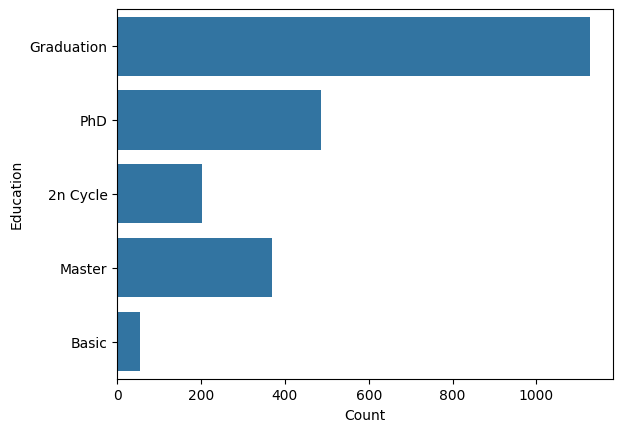

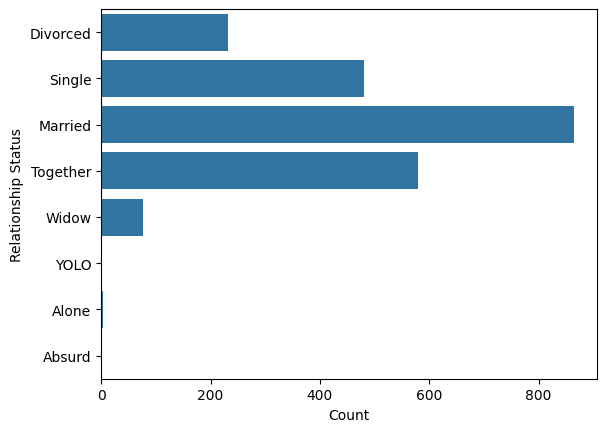

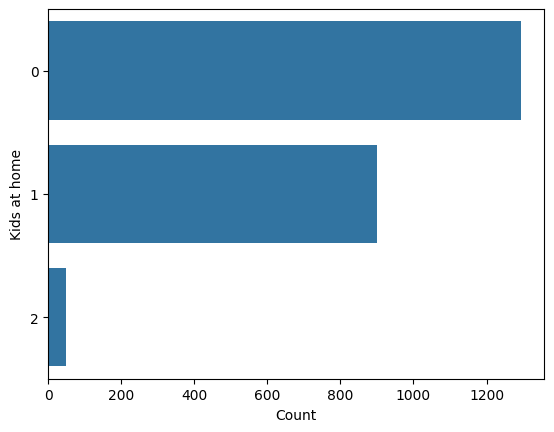

In [5]:

#Part 3 distribution of categorical variables Education, marital status

#Barplot

def plot_barplot(data, xlabel='Count', ylabel='Catergory', title='Bar Plot',savename='barbase.png'):
    plt.figure()
    sns.countplot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('Figures/'+savename,dpi=200)

#Education
Education = Dataset['Education']
Mat_Status = Dataset['Marital_Status']
TeenHome = Dataset['Teenhome'].astype('str')
plot_barplot(Education,ylabel='Education',title=None,savename='Education_bar.png')

#Marital status
plot_barplot(Dataset['Marital_Status'],ylabel='Relationship Status',title=None,savename='Marital_Status.png')

#Kids at home
plot_barplot(Dataset['Kidhome'].astype('str'),ylabel='Kids at home',title=None,savename='Kids_home.png')


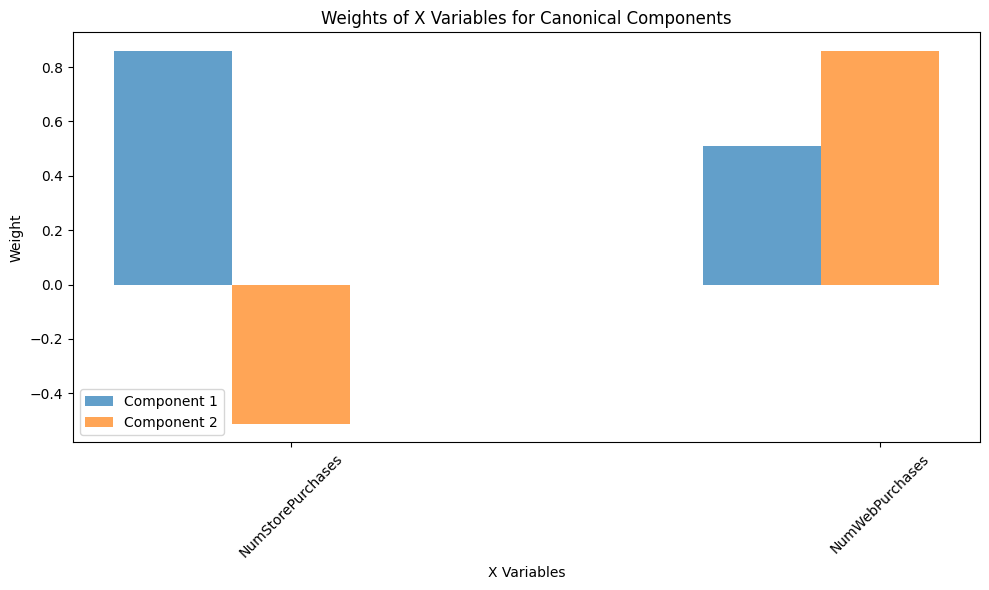

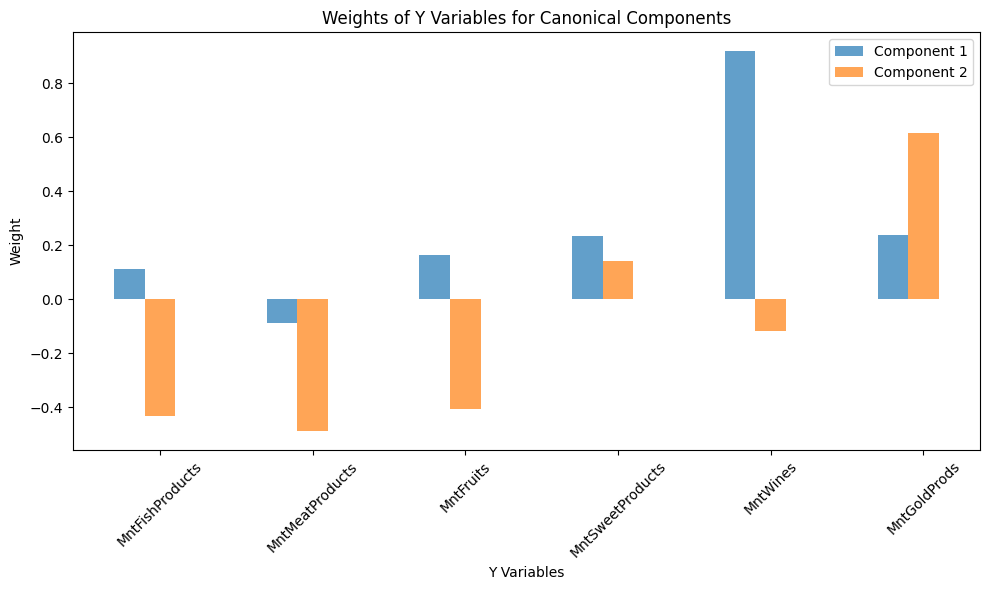

In [6]:
#Part 4) Relationship betwen number of purchases and ammount spent on different produces, do CCA

import sklearn.cross_decomposition as skcd

def cca_and_plot_weights(X_mat, Y_mat, x_labels, y_labels,num_comp=2, x_output_file='Problem2_part4_X.png', y_output_file='Problem2_part4_Y.png'):
    # Perform Canonical Correlation Analysis (CCA)
    cca = skcd.CCA(n_components=num_comp)
    cca.fit(X_mat, Y_mat)

    # Get the weights
    x_weights = cca.x_weights_
    y_weights = cca.y_weights_

    # Plot weights for X variables
    plt.figure(figsize=(10, 6))
    bar_width = 0.2

    for i in range(x_weights.shape[1]):
        plt.bar(np.arange(len(x_weights)) + (i - 1) * bar_width, x_weights[:, i], bar_width, alpha=0.7, label=f'Component {i+1}')

    plt.xlabel('X Variables')
    plt.ylabel('Weight')
    plt.title('Weights of X Variables for Canonical Components')
    plt.xticks(np.arange(len(x_weights)), x_labels, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.savefig('Figures/'+x_output_file, dpi=200)

    # Plot weights for Y variables
    plt.figure(figsize=(10, 6))

    for i in range(y_weights.shape[1]):
        plt.bar(np.arange(len(y_weights)) + (i - 1) * bar_width, y_weights[:, i], bar_width, alpha=0.7, label=f'Component {i+1}')

    plt.xlabel('Y Variables')
    plt.ylabel('Weight')
    plt.title('Weights of Y Variables for Canonical Components')
    plt.xticks(np.arange(len(y_weights)), y_labels, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.savefig('Figures/'+y_output_file, dpi=200)
    plt.show()

#Matrix for the number of purchases
Purchases = Dataset[['NumStorePurchases','NumWebPurchases']]
Mnt_spent = Dataset[['MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds']]

xlist = ['NumStorePurchases','NumWebPurchases']
ylist = ['MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds']
cca_and_plot_weights(Purchases,Mnt_spent,x_labels=xlist,y_labels=ylist,x_output_file='Purchase_X.png',y_output_file='Purchase_Y.png')



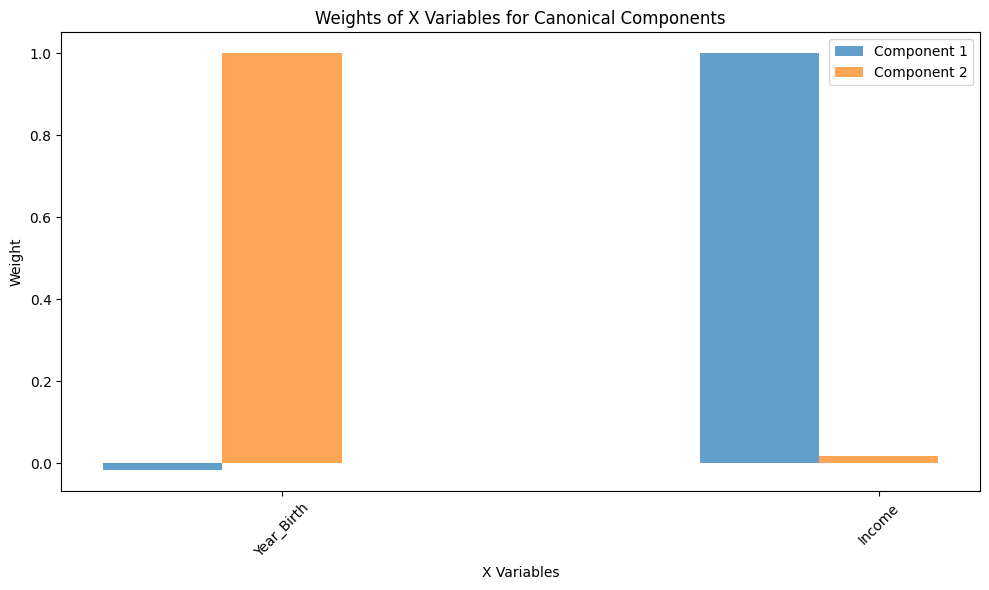

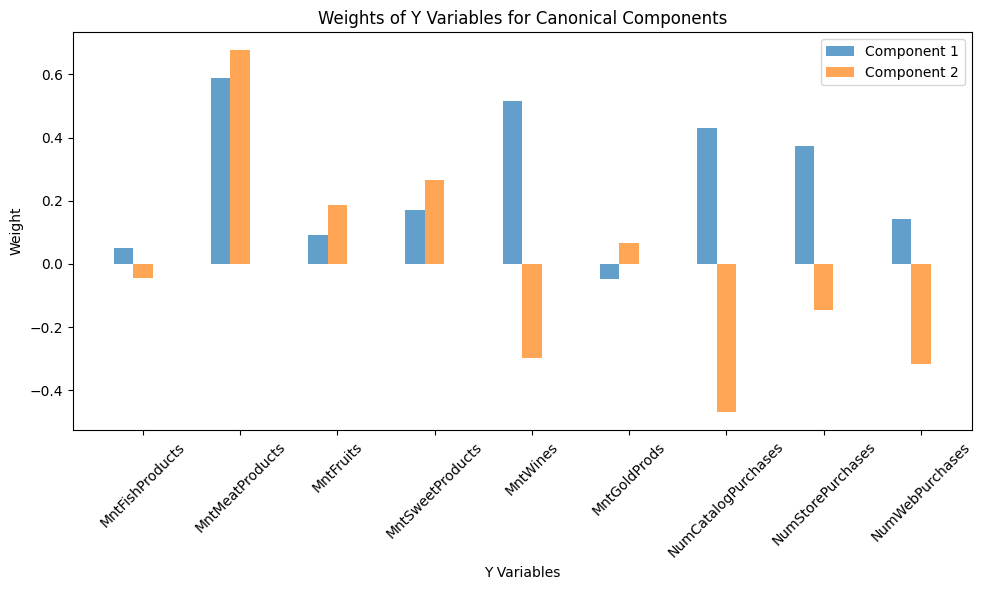

In [7]:
#Part 5 doing CCA on demographic and thier purchasing behavior

xlist = ['Year_Birth','Income']
ylist = ['MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds','NumCatalogPurchases','NumStorePurchases','NumWebPurchases']
#Matrix for the number of purchases
Demo = Dataset[['Year_Birth','Income']]
SpeningHab = Dataset[['MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds','NumCatalogPurchases','NumStorePurchases','NumWebPurchases']]


cca_and_plot_weights(Demo,SpeningHab,x_labels=xlist,y_labels=ylist,num_comp=2,x_output_file='Demographic_X.png',y_output_file='Demographic_Y.png')


In [8]:
#Part 6 Visualizing and coloring by catergoical values, I choose to use UMAP for this

#Standarize the dataset

from sklearn.preprocessing import StandardScaler
arrlen = len(Dataset.MntFishProducts)

scale = StandardScaler()
#Standarizing the continouse values
df = Dataset
contvarlist = ['Year_Birth','Income','MntFishProducts','MntMeatProducts','MntFruits','MntSweetProducts','MntWines','MntGoldProds','NumDealsPurchases','NumCatalogPurchases','NumStorePurchases','NumWebPurchases','NumWebVisitsMonth','Recency']
for i in contvarlist:
    df[i] = scale.fit_transform(np.asarray(df[i]).reshape([arrlen,1]))


df.to_csv('Data/Scaled_Imputed_income.csv')

In [9]:

#Do UMAP on the df to get the visualization
df = df[contvarlist]
reduction = umap.UMAP()

embedding = reduction.fit_transform(df,)


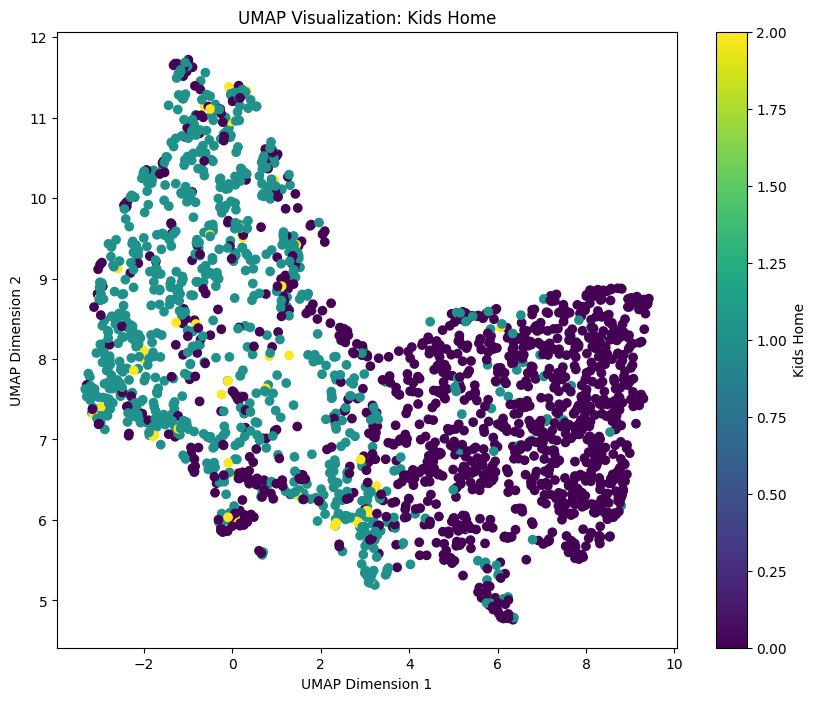

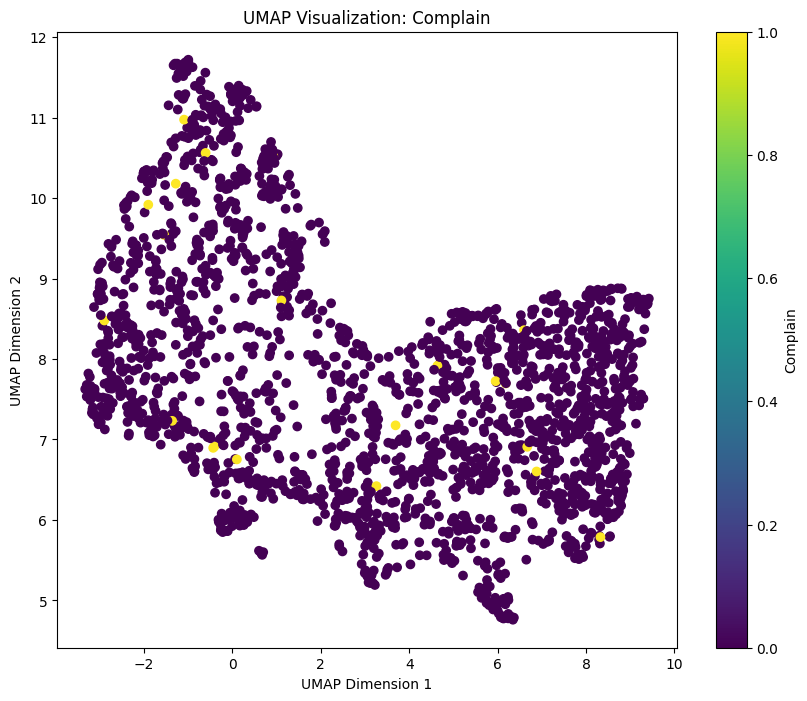

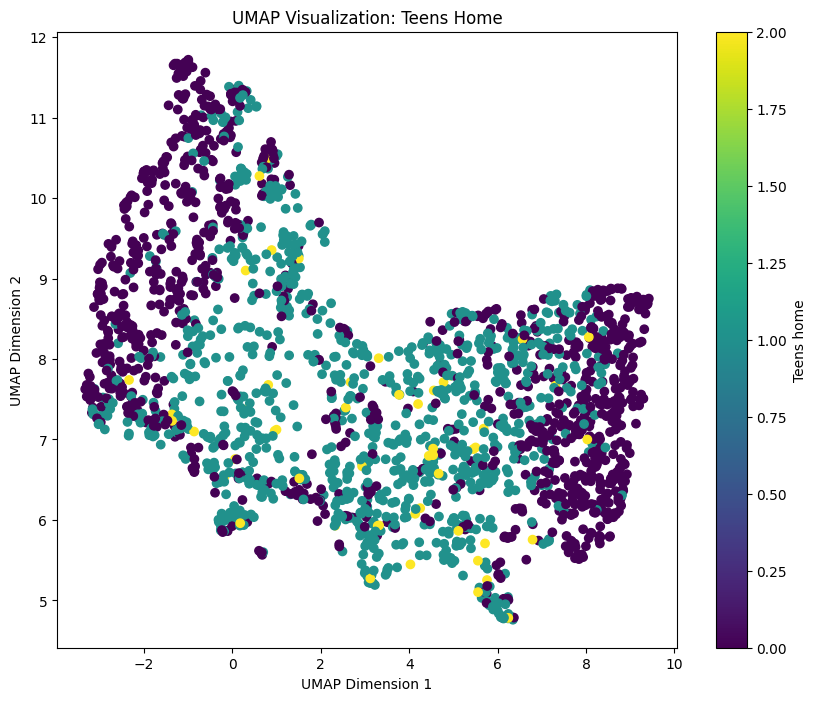

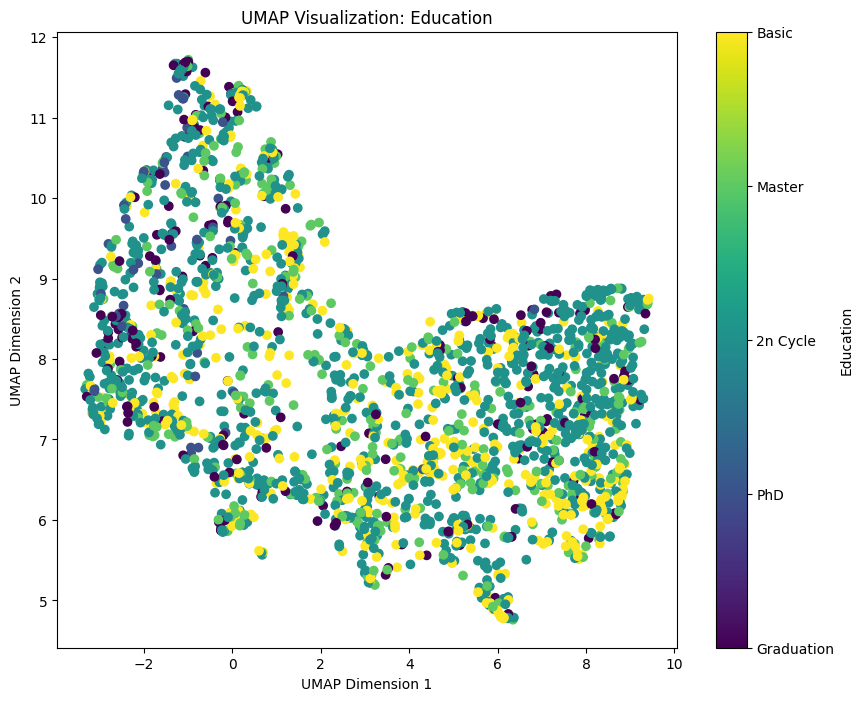

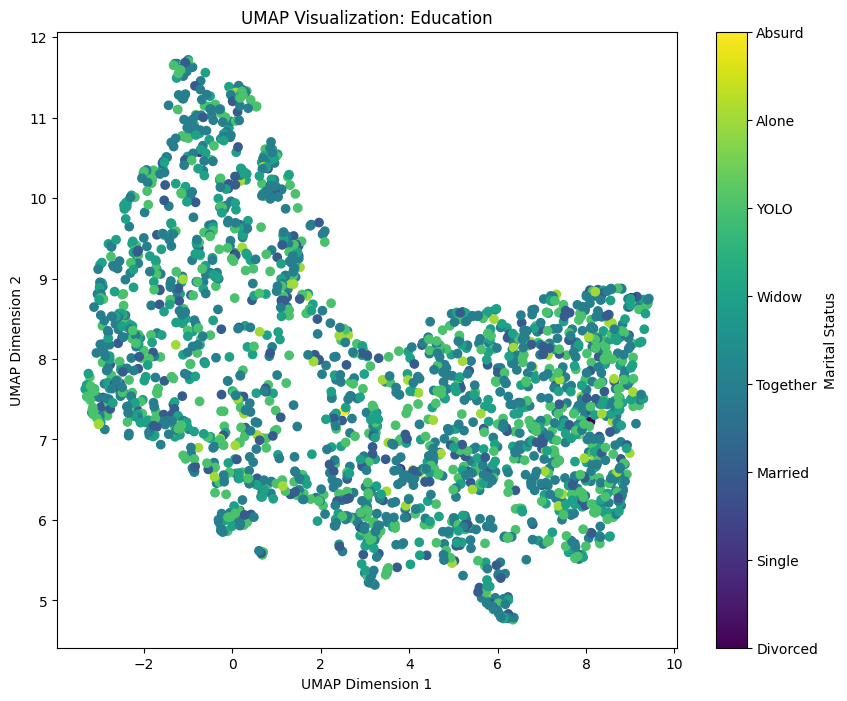

In [10]:

#show the embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Dataset['Kidhome'], cmap='viridis')
plt.colorbar(label='Kids Home')
plt.title('UMAP Visualization: Kids Home')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.savefig('Figures/UMAP_Kidhome.png',dpi=200)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Dataset['Complain'], cmap='viridis')
plt.colorbar(label='Complain')
plt.title('UMAP Visualization: Complain')
plt.xlabel('UMAP Dimension 1') 
plt.ylabel('UMAP Dimension 2')
plt.savefig('Figures/UMAP_Complain.png',dpi=200)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Dataset['Teenhome'], cmap='viridis')
plt.colorbar(label='Teens home')
plt.title('UMAP Visualization: Teens Home')
plt.xlabel('UMAP Dimension 1') 
plt.ylabel('UMAP Dimension 2')
plt.savefig('Figures/UMAP_Teens Home.png',dpi=200)

#Education
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Dataset['Education'].astype('category').cat.codes, cmap='viridis')
cb = plt.colorbar(label='Education',ticks=np.unique(Dataset['Education'].astype('category').cat.codes))
cb.ax.set_yticklabels(Dataset['Education'].unique())
plt.title('UMAP Visualization: Education')
plt.xlabel('UMAP Dimension 1') 
plt.ylabel('UMAP Dimension 2')
plt.savefig('Figures/UMAP_Education.png',dpi=200)


#matrial Status
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Dataset['Marital_Status'].astype('category').cat.codes, cmap='viridis')
cb = plt.colorbar(label='Marital Status',ticks=np.unique(Dataset['Marital_Status'].astype('category').cat.codes))
cb.ax.set_yticklabels(Dataset['Marital_Status'].unique())
plt.title('UMAP Visualization: Education')
plt.xlabel('UMAP Dimension 1') 
plt.ylabel('UMAP Dimension 2')
plt.savefig('Figures/UMAP_MaritalStatus.png',dpi=200)



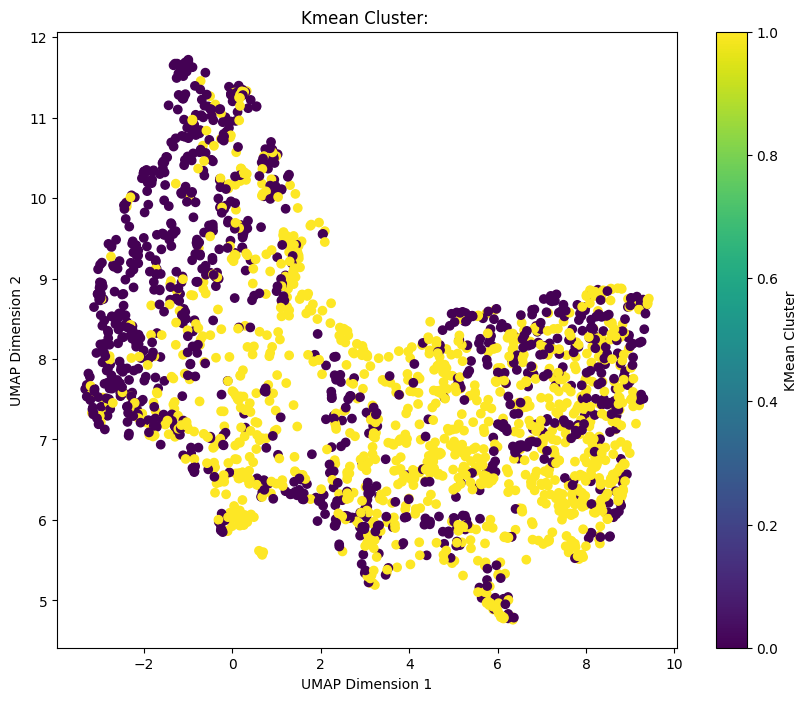

In [11]:
#Part 2.7 K means clustering

from sklearn.cluster import KMeans

#standarize dummy year birth and income to give better clusters
Dataset_dummy = Dataset
Dataset_dummy['Year_Birth'] = scale.fit_transform(np.asarray(Dataset['Year_Birth']).reshape([arrlen,1]))
Dataset_dummy['Income'] = scale.fit_transform(np.asarray(Dataset['Income']).reshape([arrlen,1]))

kmeans = KMeans(n_clusters=2,random_state=1)

clusters = kmeans.fit_predict(Dataset_dummy[['Year_Birth','Edu_Cat','Income','Mat_Cat']])

Dataset['Cluster_Cat'] = clusters

#visualize
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Dataset['Cluster_Cat'], cmap='viridis')
plt.colorbar(label='KMean Cluster')
plt.title('Kmean Cluster: ')
plt.xlabel('UMAP Dimension 1') 
plt.ylabel('UMAP Dimension 2')
plt.savefig('Figures/KMeans_Cat.png',dpi=200)


In [12]:
#2.8 Trend of NumWebVisitsMonth 

Dataset = pd.read_csv('Data/superstore_data.csv')
print(Dataset.shape)
Dataset.head()
#make new dummy columns for the education and martial status value 
Dataset_dummy = pd.get_dummies(Dataset[['Marital_Status','Education']])

Dataset = pd.concat([Dataset,Dataset_dummy],axis=1)

# Convert 'Dt_Customer' to datetime
Dataset['Dt_Customer'] = pd.to_datetime(Dataset['Dt_Customer'])

# Extract month and year from 'Dt_Customer'
Dataset['Enrollment_Month'] = Dataset['Dt_Customer'].dt.month
Dataset['Enrollment_Year'] = Dataset['Dt_Customer'].dt.year
Dataset['Enrollment_Day'] = Dataset['Dt_Customer'].dt.day
u = 0
for i in range(len(Dataset['Income'])):
    if pd.isna(Dataset['Income'][i]):
        Dataset['Income'][i] = imputed_income[u]
        u+= 1




#sort Dataset by enrollment
Dataset.sort_values(by='Dt_Customer',inplace=True)
Dataset = Dataset.reset_index()

# user_count = Dataset.groupby(['Enrollment_Year','Enrollment_Month']).size().reset_index(name='Num_MonthAdded_Users')
# #Add the number of added users to the list
# Dataset = pd.merge(Dataset, user_count, on=['Enrollment_Year', 'Enrollment_Month'], how='left')

# #Make a new column that has the total number of web visits in the month, and another one that will do the average visits per person using the website
# total_visits = Dataset.groupby(['Enrollment_Year','Enrollment_Month'])['NumWebVisitsMonth'].sum().reset_index()

# #Getting the total month 
# total_visits['Total_Webvisits'] = total_visits.groupby(['Enrollment_Year', 'Enrollment_Month'])['NumWebVisitsMonth'].cumsum()

# Dataset = pd.merge(Dataset, total_visits, on=['Enrollment_Year','Enrollment_Month'], how='left')

#Getting total number of users, and the 
Dataset['Num_Users_Total'] = Dataset.index +1 
Dataset['TotalVisitsWeb'] = Dataset['NumWebVisitsMonth'].cumsum()
Dataset['TotalMntMeat'] = Dataset['MntMeatProducts'].cumsum()
Dataset['TotalMntWine'] = Dataset['MntWines'].cumsum()
Dataset['TotalMntFruit'] = Dataset['MntFruits'].cumsum()

#Getting the average
Dataset['Average_Uses'] = Dataset['TotalVisitsWeb']/Dataset['Num_Users_Total']
Dataset['Average_Meat'] = Dataset['TotalMntMeat']/Dataset['Num_Users_Total']
Dataset['Average_Wine'] = Dataset['TotalMntWine']/Dataset['Num_Users_Total']
Dataset['Average_Fruit'] = Dataset['TotalMntFruit']/Dataset['Num_Users_Total']

Dataset.head()

Dataset.to_csv('Data/WebUsers.csv')


(2240, 22)


/tmp/ipykernel_13511/2927753707.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Dataset['Income'][i] = imputed_income[u]
/tmp/ipykernel_13511/2927753707.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

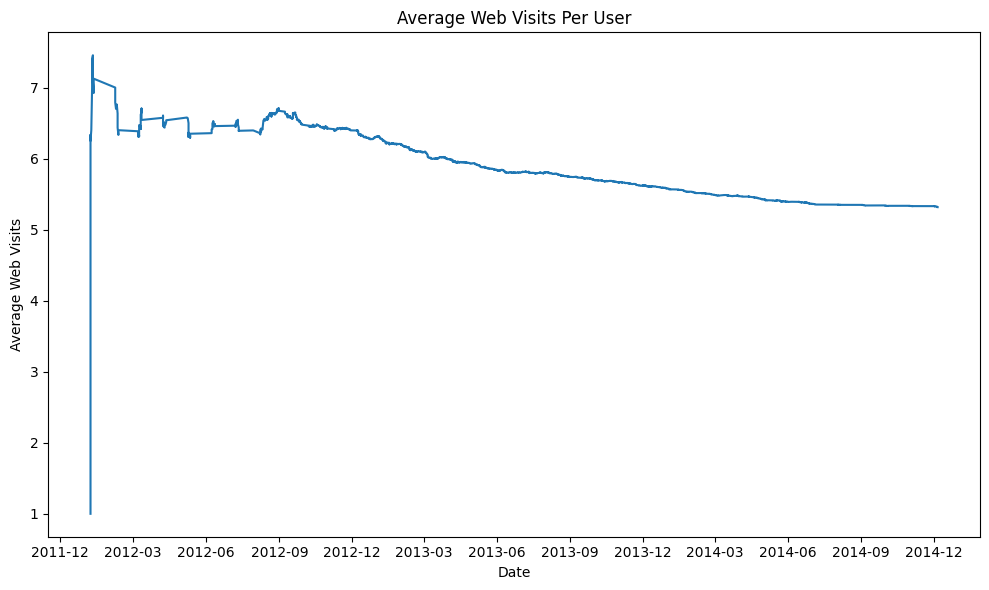

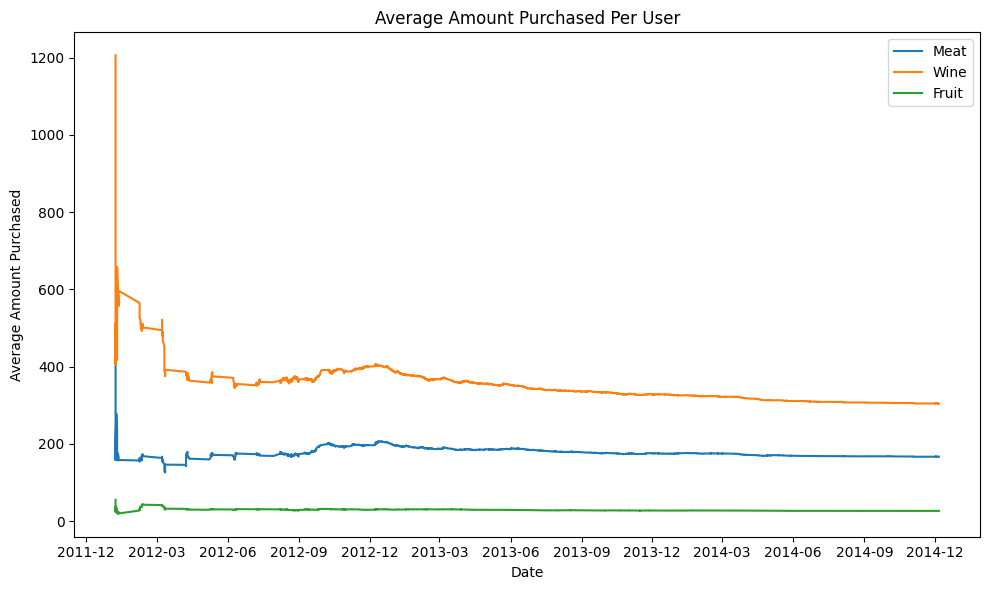

In [13]:
#Part 8 Time series behavior

plt.figure(figsize=(10, 6))
plt.plot(Dataset['Dt_Customer'], Dataset['Average_Uses'])

# Set the locator for x-axis ticks to a MonthLocator with a step of 3 months
plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Average Web Visits')
plt.title('Average Web Visits Per User')
plt.tight_layout()
plt.savefig('Figures/Avg_WebUses.png',dpi=200)

plt.figure(figsize=(10,6))
plt.plot(Dataset['Dt_Customer'], Dataset['Average_Meat'],label='Meat')
plt.plot(Dataset['Dt_Customer'], Dataset['Average_Wine'],label='Wine')
plt.plot(Dataset['Dt_Customer'], Dataset['Average_Fruit'],label='Fruit')
# Set the locator for x-axis ticks to a MonthLocator with a step of 3 months
plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))

plt.xlabel('Date')
plt.legend()
plt.ylabel('Average Amount Purchased')
plt.title('Average Amount Purchased Per User')
plt.tight_layout()
plt.savefig('Figures/Mnt_Trends.png',dpi=200)



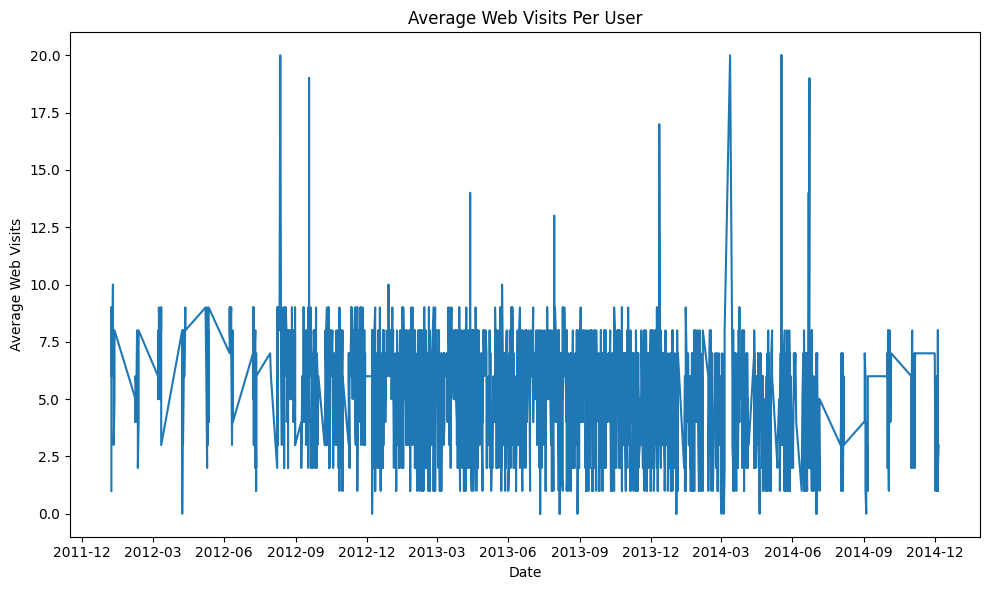

In [14]:

#Redoing the time plots by day for customer
plt.figure(figsize=(10, 6))
plt.plot(Dataset['Dt_Customer'], Dataset['NumWebVisitsMonth'])

# Set the locator for x-axis ticks to a MonthLocator with a step of 3 months
plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Average Web Visits')
plt.title('Average Web Visits Per User')
plt.tight_layout()
plt.savefig('Figures/Granular_WebUses.png',dpi=200)